In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

# Загрузка данных

При загрузке данных передадим дату в индекс:

In [2]:
df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Отсортируем данные:

In [4]:
df.sort_index(inplace=True) 

Выполним ресемплирование данных по одному часу:

In [5]:
df=df.resample('1H').sum()

In [6]:
df.shape

(4416, 1)

Максимальная и минимальная даты:

In [7]:
df.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

In [8]:
df.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

Визуализируем временной ряд:

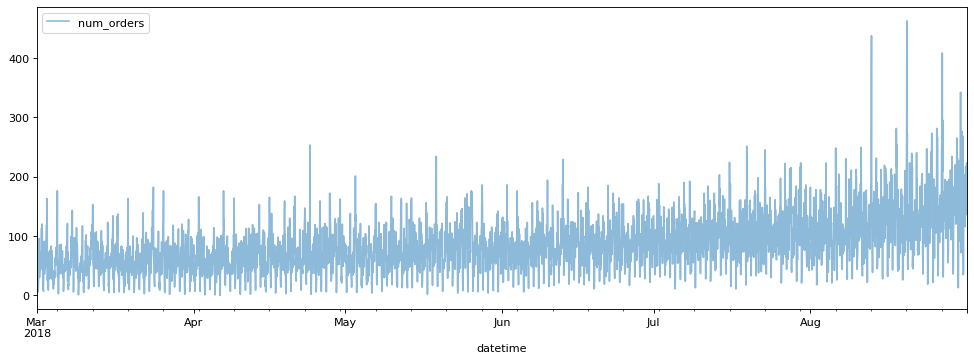

In [9]:
plt.figure(figsize=(15, 5), dpi=80)
df.plot(ax=plt.gca(), alpha=0.5)
plt.show()

# Анализ данных

Часто данные бывают зашумлены, в них бывают выбросы, чтоб определить тренд испльзуют скользящее среднее.

In [10]:
def plotMovingAverage(data, n, plot_bounds=False): # где data - временной ряд, n - размер скользящего окна,  plot_bounds=False - 
    # доверительный интервал
    
    rolling_mean = data.rolling(window=n).mean()
        
    fig, ax = plt.subplots(figsize=(15,5))
    
    plt.plot(data[n:], label="Актуальное значение", alpha = 0.5)
    plt.legend(loc="upper left")
    plt.grid(True)
    
    plt.title("Скользящее среднее\размер окна = {}".format(n))
    plt.plot(rolling_mean, "g", label="Тенденция скользящего среднего")

    # доверительные интервалы для сглаженных значений (если указать plot_bounds=True)
    if plot_bounds:
        rolling_std =  data.rolling(window=n).std()
        upper_bound = rolling_mean+1.96*rolling_std #верхняя граница доверительного периода
        lower_bound = rolling_mean-1.96*rolling_std #нижняя граница доверительного периода
        plt.plot(upper_bound, "r--", label="Верхняя граница/Нижняя граница")
        plt.plot(lower_bound, "r--")
   
    # Деления соответствуют понедельникам что дает представление о недельной цикличности графика
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    # Отображать значение дат в формате yy-mm-dd
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'));
    plt.xticks(rotation=45)

Сглаживание по дням:

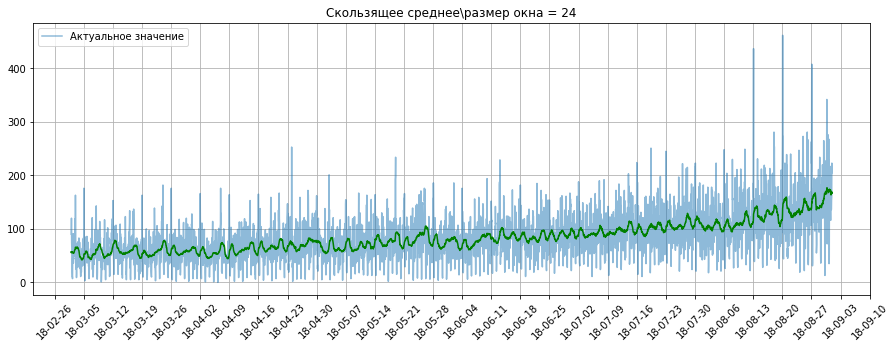

In [11]:
plotMovingAverage(df, 24)

Сглаживание по неделям:

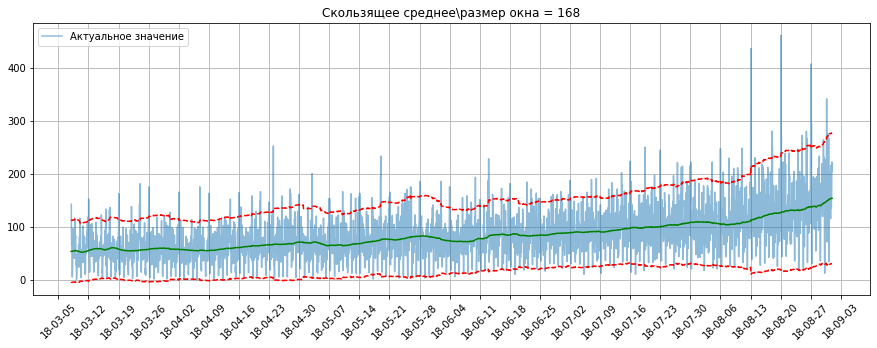

In [12]:
plotMovingAverage(df, 24*7, plot_bounds=True)

Наблюдается восходящий трэнд к началу сентября, который скорей всего будет и дальше сохранятся. Посмотрим на сезонность, тренд и шумы с помощью  метода seasonal_decompos():

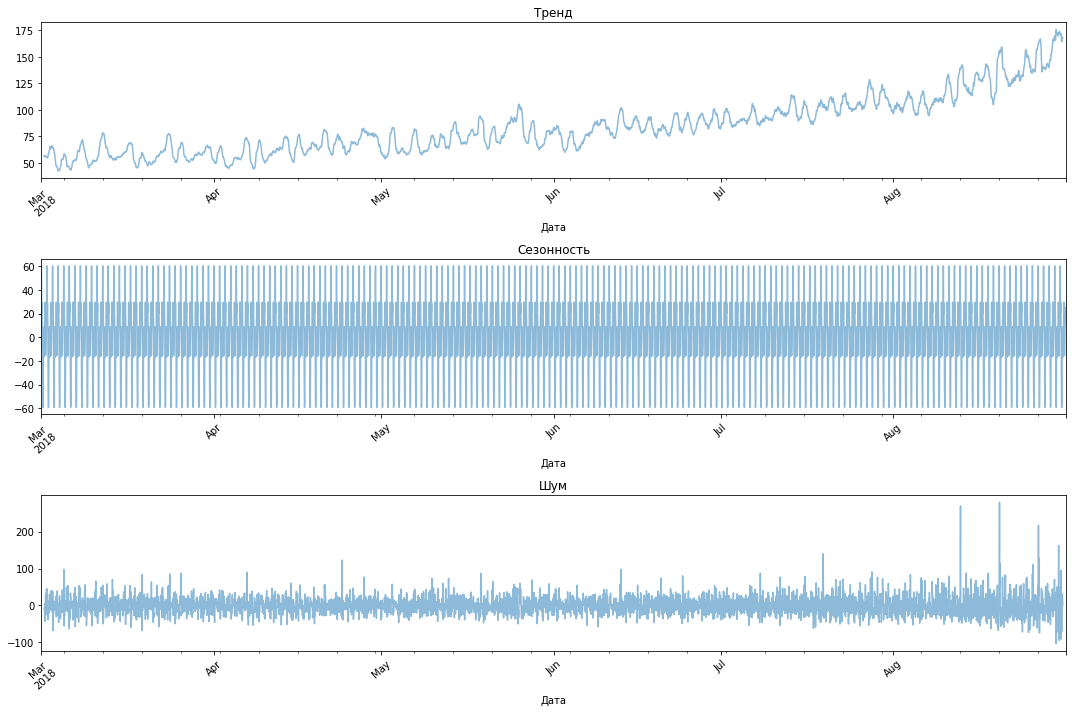

In [13]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), alpha=.5)
plt.title('Тренд')
plt.xticks(rotation=42)
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), alpha=.5) 
plt.title('Сезонность')
plt.xticks(rotation=42)
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), alpha=.5) 
plt.title('Шум')
plt.xticks(rotation=42)
plt.xlabel('Дата')

plt.tight_layout()

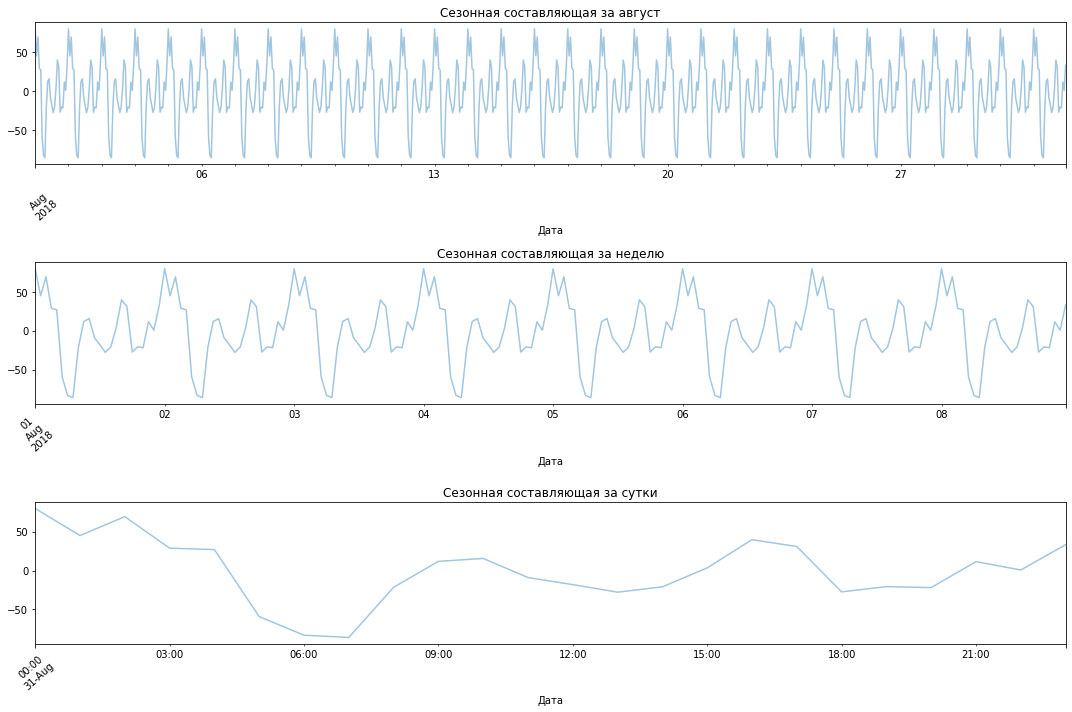

In [14]:
plt.figure(figsize=(15, 10))
Q2 = df['2018-08-01':'2018-08-31']
decomposed = seasonal_decompose(Q2)

plt.subplot(311)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca(), alpha=.42)
plt.xlabel('Дата')
plt.xticks(rotation=42)
plt.title('Сезонная составляющая за август')

plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-08'].plot(ax=plt.gca(), alpha=.42)
plt.title('Сезонная составляющая за неделю')
plt.xticks(rotation=42)
plt.xlabel('Дата')

plt.subplot(313)
decomposed.seasonal['2018-08-31':'2018-08-31'].plot(ax=plt.gca(), alpha=.42)
plt.title('Сезонная составляющая за сутки')
plt.xticks(rotation=42)
plt.xlabel('Дата')


plt.tight_layout()

За день хорошо видна сезонность - к 6 утра заказы резко падают и после снова начинают расти, просматривается тенденция рабочего дня, когда такси чаще вызывают утром и после 16.00, а также спрос возрастает в ночное время суток. 

Также необходимо проверить данные на стационарность. Если данные не стационарны, модель невозможно спрогназировать.

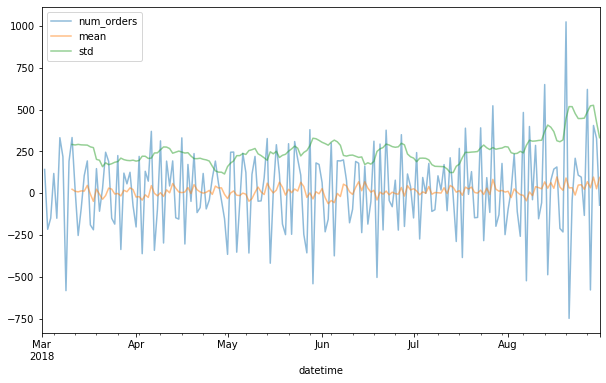

In [15]:
data = df.resample('1D').sum()
data = data - data.shift() 
data['mean'] = data['num_orders'].rolling(10).mean()
data['std'] = data['num_orders'].rolling(10).std()
plt.figure(figsize=(10, 6))
data.plot(ax=plt.gca(), alpha=0.5)
plt.show()

Данные стационарны - их можно прогнозировать

# Дополнительные признаки

Для прогнозирования данных добавим новые признаки, такие как календарные признаки (месяц, день), отстающие признаки и скользящее среднее.

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [17]:
new_df = make_features(df, 25, 20)

In [18]:
new_df.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Выбор модели

Удалим пропущенные данные:

In [19]:
new_df.dropna(inplace=True)

Разделим датасет на обучающую и тестовую выборки:

In [20]:
train, test = train_test_split(new_df, shuffle=False, test_size=0.1)

In [21]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [22]:
X_train, y_train = split_data(train, 'num_orders')
X_test, y_test = split_data(test, 'num_orders')
X_train.shape, X_test.shape

((3951, 29), (440, 29))

Первая модель, которой мы воспользуемся - модель ближайших соседей:

In [23]:
tscv = TimeSeriesSplit(n_splits=5)

In [24]:
param_grid = {
    "n_neighbors": [2, 5, 7, 10],
    "weights": ["uniform", "distance"]
}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(
    knn, 
    param_grid, 
    cv=tscv, 
    n_jobs=-1, 
    scoring="neg_root_mean_squared_error" 
)

grid_search.fit(X_train, y_train)

print("лучшие гиперпараметры:", grid_search.best_params_)
best_knn = grid_search.best_estimator_
rmse = - grid_search.best_score_ 
print("RMSE:", rmse)


лучшие гиперпараметры: {'n_neighbors': 7, 'weights': 'distance'}
RMSE: 25.938795656183196


Модель опорных векторов:

In [25]:
param_grid = {
    "C": [0.1, 1, 10],
    "epsilon": [0.01, 0.1, 1],
    "gamma": ["scale", "auto"]
}

svr = SVR()

grid_search = GridSearchCV(
    svr, 
    param_grid, 
    cv=tscv, 
    n_jobs=-1, 
    scoring="neg_root_mean_squared_error" 
)

grid_search.fit(X_train, y_train)

print("лучшие гиперпараметры:", grid_search.best_params_)
best_svr = grid_search.best_estimator_
rmse = - grid_search.best_score_ 
print("RMSE:", rmse)

лучшие гиперпараметры: {'C': 10, 'epsilon': 1, 'gamma': 'scale'}
RMSE: 27.77654662356475


Модель случайный лес:

In [26]:
param_grid = {
    "n_estimators": [200, 250],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rfr = RandomForestRegressor()

grid_search = GridSearchCV(
    rfr, 
    param_grid, 
    cv=tscv, 
    n_jobs=-1, 
    scoring="neg_root_mean_squared_error" 
)

grid_search.fit(X_train, y_train)

print("лучшие гиперпараметры:", grid_search.best_params_)
best_rfr = grid_search.best_estimator_
rmse = - grid_search.best_score_ 
print("RMSE:", rmse)

лучшие гиперпараметры: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
RMSE: 25.948537847317276


Лучшая модель - случайный лес. Протестируем ее на отложенных данных:

In [27]:
y_pred = best_rfr.predict(X_test)

In [28]:
final_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
final_RMSE

42.950060879551216

Визуализируем предсказанные значения и исходные значения:

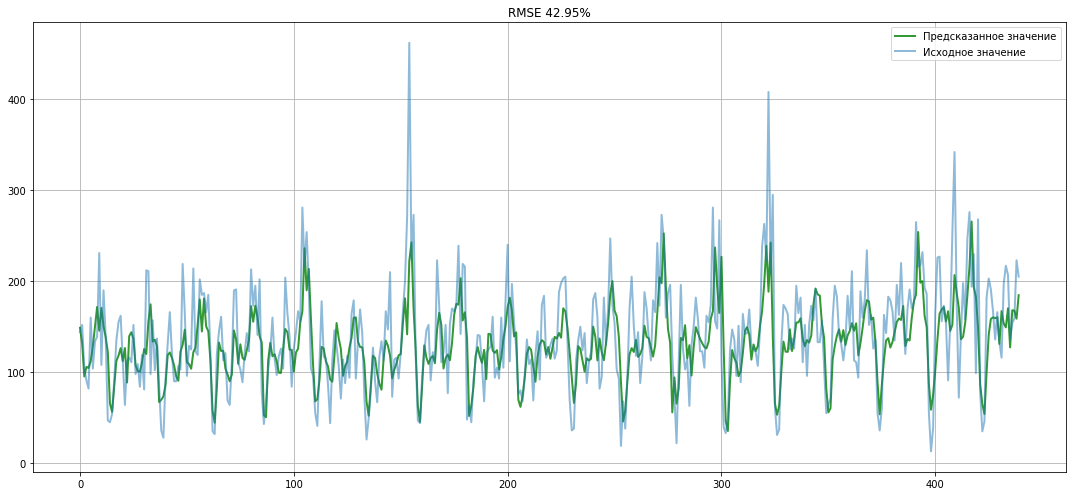

In [29]:
plt.figure(figsize=(15, 7))
plt.plot(y_pred, "g", label="Предсказанное значение", linewidth=2.0, alpha=.8)
plt.plot(y_test.values, label="Исходное значение", linewidth=2.0, alpha=.5)
plt.title("RMSE {0:.2f}%".format(final_RMSE))
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True)

Посмотрим на важность признаков:

In [30]:
feature_importances = pd.DataFrame(best_rfr.feature_importances_, X_train.columns)

In [31]:
feature_importances.columns = ["importances"]

In [32]:
feature_importances = feature_importances.sort_values(by="importances", ascending=False)

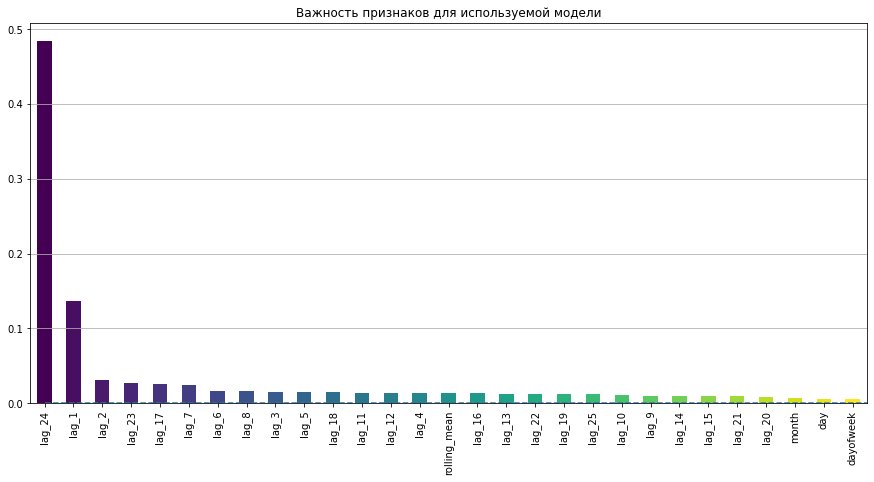

In [36]:
num_colors = len(feature_importances)
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
plt.figure(figsize=(15, 7))
feature_importances.importances.plot(kind='bar', color=colors)
plt.grid(True, axis='y')
plt.title('Важность признаков для используемой модели')
plt.hlines(y=0, xmin=0, xmax=len(feature_importances), linestyles='dashed')
plt.show()

Вывод: мы рассмотрели промежуток временного ряда с марта по август 2018 года по количеству вызовов такси, обнаружили в данных закономерности, проверили на стационарность. Создали новые признаки, которые оказались очень важны для построения модели. Проверили три модели для прогнозирования временных рядов, лучшей оказалась модель - случайный лес, ее RMSE удовлетворяет условия заказчика - 43.